In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from params import params
from const import src_path, dst_path, left, top, width, height, fps

In [3]:
def load_avi(path, interval, start, nframe):
    cap = cv2.VideoCapture(path)
    _, im = cap.read()
    cap.release()
    H, W, _ = im.shape
    ret = np.zeros((nframe, H, W), dtype=im.dtype)
    
    cap = cv2.VideoCapture(path)
    cnt = 0; cnt_save = 0
    while(cap.isOpened()):
        _, im = cap.read()
        cnt += 1
        if cnt % interval == 0:
            if cnt // interval < start: continue
            ret[cnt_save,:,:] = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            cnt_save += 1
            if cnt_save >= nframe: break            
    cap.release()
    
    return ret.astype(np.float64)

In [4]:
sorted(params.keys())

['20170905-1',
 '20170921-1',
 '20170921-2',
 '20170925-1',
 '20171020-1',
 '20171020-2',
 '20171020-3',
 '20171117-1',
 '20171120-2',
 '20171120-3']

/mnt/Omer/Project/14.SuizoAssyuku/data/20170905-1/3_CMG0_HIGAIN3_add_10~20min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20170905-1/5_CMG0_HIGAIN3_add_compress_add_20~30min.avi


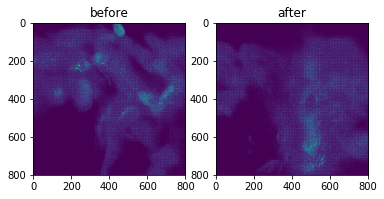

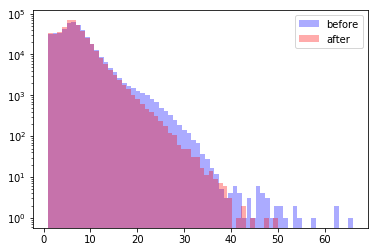

/mnt/Omer/Project/14.SuizoAssyuku/data/20170921-1/2_CMG0_HIGAIN3_0~10min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20170921-1/5_CMG0_HIGAIN3_add_compress_add_20~30min.avi


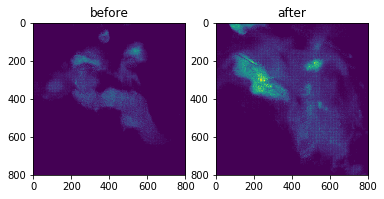

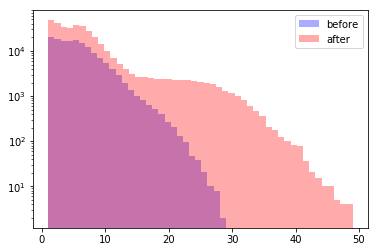

/mnt/Omer/Project/14.SuizoAssyuku/data/20170921-2/2_CMG0_HIGAIN3_0~10min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20170921-2/5_CMG0_HIGAIN3_add_compress_add_20~30min.avi


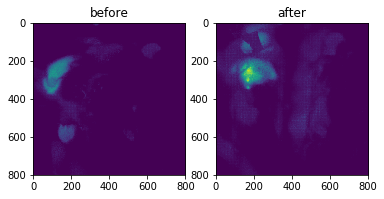

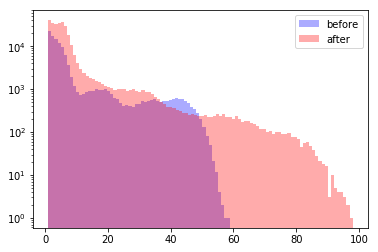

/mnt/Omer/Project/14.SuizoAssyuku/data/20170925-1/2_CMG0_HIGAIN3_0~10min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20170925-1/5_CMG0_HIGAIN3_add_compress_add_20~30min.avi


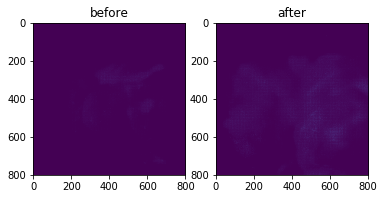

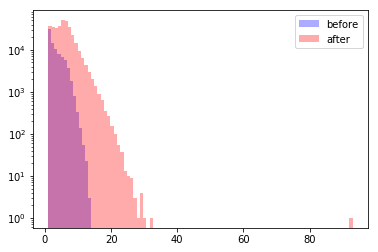

/mnt/Omer/Project/14.SuizoAssyuku/data/20171020-1/2_CMG0_HIGAIN3_0~5min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20171020-1/4_CMG0_HIGAIN3_compress_add_5~10min.avi


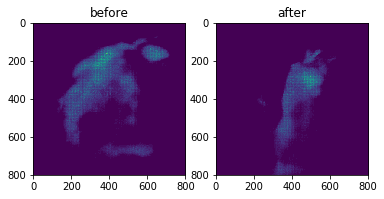

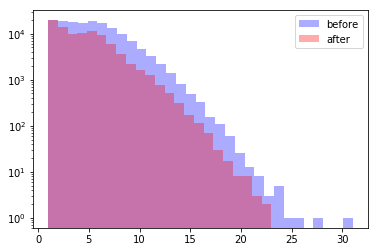

/mnt/Omer/Project/14.SuizoAssyuku/data/20171020-2/2_CMG0_HIGAIN3_0~5min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20171020-2/5_CMG0_HIGAIN3_add_compress_add_10~15min.avi


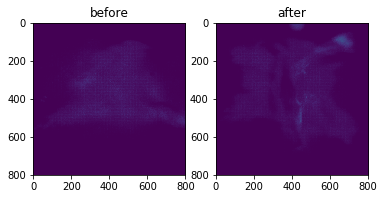

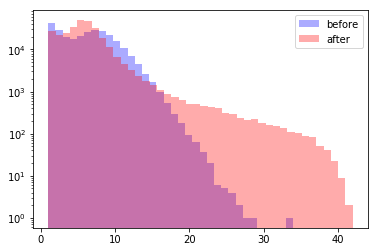

/mnt/Omer/Project/14.SuizoAssyuku/data/20171020-3/2_CMG0_HIGAIN3_0~5min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20171020-3/5_CMG0_HIGAIN3_add_compress_add_10~15min.avi


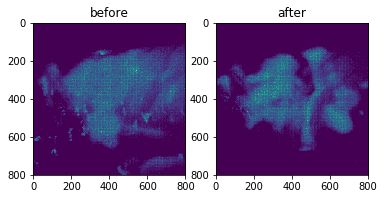

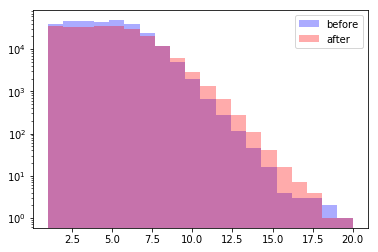

/mnt/Omer/Project/14.SuizoAssyuku/data/20171117-1/3_CMG0_HIGAIN3_add_5~10min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20171117-1/5_CMG0_HIGAIN3_add_compress_add_10~15min.avi


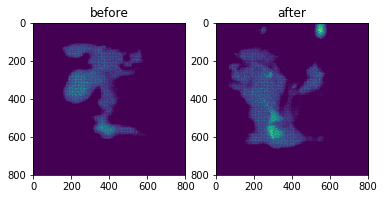

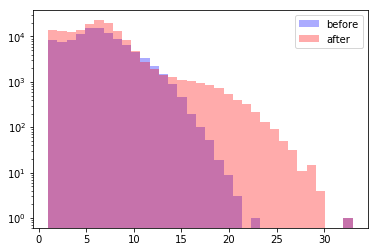

/mnt/Omer/Project/14.SuizoAssyuku/data/20171120-2/3_CMG0_HIGAIN3_add_5~10min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20171120-2/5_CMG0_HIGAIN3_add_compress_add_10~15min.avi


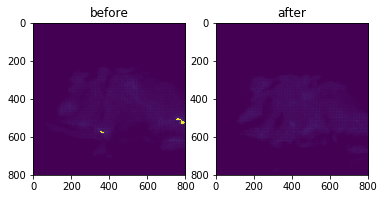

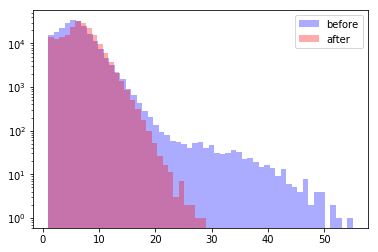

/mnt/Omer/Project/14.SuizoAssyuku/data/20171120-3/2_CMG0_HIGAIN3_0~5min.avi
/mnt/Omer/Project/14.SuizoAssyuku/data/20171120-3/6_CMG0_HIGAIN3_add_compress_add_add_15~20min.avi


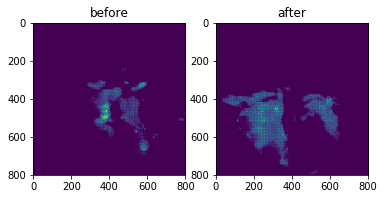

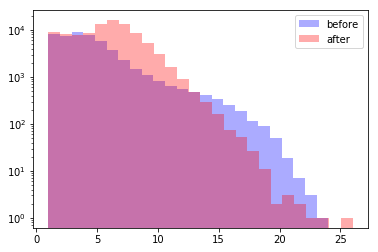

In [21]:
with open(os.path.join(dst_path, 'mean.txt'),'w') as f:
    for key in sorted(params.keys()):
        ims = {}
        save_path = os.path.join(dst_path, key)
        if not os.path.exists(save_path) : os.makedirs(save_path)

        for phase in ["before", "after"]:

            param = params[key][phase]
            path = src_path+'{0}/{1}'.format(key, param["path"])
            print(path)
            mov = load_avi(path, fps, param["start"], param["nframe"])
            mov = mov[:,top:top+height,left:left+width]
            mov_slope = np.zeros_like(mov)
            mov_slope[1:,:,:] = mov[1:,:,:] - mov[:-1,:,:]
            mov_slope = mov_slope[1:,:,:]
            im_slope = np.max(mov_slope, axis=0)
            np.save(os.path.join(save_path, 'slope_{0}'.format(phase)), im_slope)
            ims[phase] = im_slope

        f.writelines('{0},{1},{2}\n'.format(key,np.mean(ims['before']), np.mean(ims['after'])))

        vmax = max(ims["before"].max(), ims["after"].max())
        plt.subplot(121)
        plt.imshow(ims["before"], vmax=vmax)
        plt.title('before')
        plt.subplot(122)
        plt.imshow(ims["after"], vmax=vmax)
        plt.title('after')
        plt.savefig(os.path.join(save_path, 'image_slope.png'))
        plt.show()

        cols = {"before": 'b', "after": 'r'}
        for phase in ["before", "after"]:
            im = ims[phase]
            im *= (im<100)*1
            im = im.flatten()
            plt.hist(im[np.where(im>0)], bins = int(np.max(im)), alpha = 0.33, histtype = 'stepfilled', color = cols[phase], label=phase)
        plt.yscale("log")
        plt.legend()
        plt.savefig(os.path.join(save_path, 'histogram.png'))
        plt.show()